In [ ]:
!pip install lightning-bolts pytorch-lightning

In [1]:
from pl_bolts.models.autoencoders import VAE
from pl_bolts.models.vision import PixelCNN
from torchvision import datasets, transforms
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
import numpy as np

In [2]:
class HorizontalHalfCropCIFAR10(datasets.CIFAR10):
    def __init__(
            self,
            root,
            train = True,
            transform = None,
            target_transform = None,
            download = False,
    ):
        super().__init__(root=root, train=train, transform=transform, target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)
        
        img_top = img.clone()
        img_top[:, 16:, :] = 0
        img_bot = img.clone()
        img_bot[:, :16, :] = 0

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, img_top, img_bot, target

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
    #     std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
    # )
])

In [4]:
batch_size = 100

trainset = HorizontalHalfCropCIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)

testset = HorizontalHalfCropCIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
x, x_top, x_bot, y = next(iter(trainloader))
print(x.shape, x_top.shape, x_bot.shape, y.shape)

torch.Size([100, 3, 32, 32]) torch.Size([100, 3, 32, 32]) torch.Size([100, 3, 32, 32]) torch.Size([100])


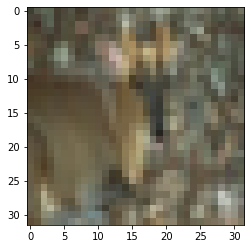

In [6]:
plt.imshow(x[0].permute(1, 2, 0).detach().cpu())

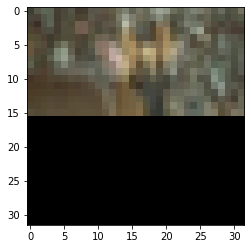

In [7]:
plt.imshow(x_top[0].permute(1, 2, 0).detach().cpu())

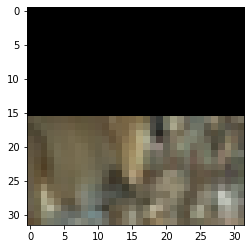

In [8]:
plt.imshow(x_bot[0].permute(1, 2, 0).detach().cpu())

In [9]:
class PixelVAE(VAE):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pixelcnn = PixelCNN(3)
        self.decoder = nn.Sequential(
            self.decoder,
            self.pixelcnn
        )

    def step(self, batch, batch_idx):
        x, x_top, x_bot, y = batch
        z, x_hat, p, q = self._run_step(x_top)

        recon_loss = F.mse_loss(x_hat, x, reduction='mean')

        log_qz = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = log_qz - log_pz
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

In [10]:
model = PixelVAE(enc_type='resnet18', input_height=32)
# model = PerturbVAE(input_height=32).from_pretrained('cifar10-resnet18')

In [11]:
trainer = Trainer(gpus=1, max_epochs=30)
trainer.fit(model, train_dataloader=trainloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/alireza/miniconda3/envs/maedeh/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type          | Params
-------------------------------------------
0 | encoder  | ResNetEncoder | 11.2 M
1 | decoder  | Sequential    | 10.3 M
2 | fc_mu    | Linear        | 131 K 
3 | fc_var   | Linear        | 131 K 
4 | pixelcnn | PixelCNN      | 1.6 M 
-------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.828    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/alireza/miniconda3/envs/maedeh/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


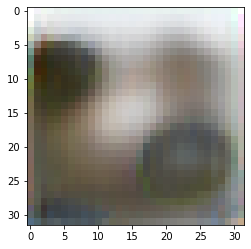

In [12]:
plt.imshow(model(x_top[:1]).squeeze().permute(1, 2, 0).detach().cpu())

# Linear Classification

In [13]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [15]:
latent = []
labels = []
for idx, (x, x_top, x_bot, y) in enumerate(tqdm(trainloader)):
#     z, x_hat, p, q = model._run_step(x_perturb)
    x = model.encoder(x_top)

    mu = model.fc_mu(x)

    log_var = model.fc_var(x)

    p, q, z = model.sample(mu, log_var)
    
    z=z.detach().cpu().numpy()
    latent.append(z)
    labels.append(y)
# x, x_perturb, y = next(iter(trainloader))

100%|██████████| 500/500 [03:03<00:00,  2.73it/s]


In [16]:
z = np.concatenate(latent)

In [17]:
y = np.concatenate(labels)

In [18]:
clf = LogisticRegression(random_state=0, max_iter=5000).fit(z, y)

In [19]:
clf.score(z, y)

0.29946

In [22]:
latent2 = []
labels2 = []
for idx, (x, x_top, x_bot, y) in enumerate(tqdm(testloader)):
#     z, x_hat, p, q = model._run_step(x_perturb)
    x = model.encoder(x_top)

    mu = model.fc_mu(x)

    log_var = model.fc_var(x)

    p, q, z = model.sample(mu, log_var)
    
    z=z.detach().cpu().numpy()
    latent2.append(z)
    labels2.append(y)

100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


In [23]:
z = np.concatenate(latent2)

In [24]:
y = np.concatenate(labels2)

In [25]:
clf = LogisticRegression(random_state=0, max_iter=5000).fit(z, y)

In [26]:
clf.score(z, y)

0.3358

#Linear Classification

In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [ ]:
latent = []
labels = []
for idx, (x, x_perturb, y) in enumerate(tqdm(trainloader)):
    z, x_hat, p, q = model._run_step(x_perturb)
    z=z.detach().cpu().numpy()
    latent.append(z)
    labels.append(y)
# x, x_perturb, y = next(iter(trainloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
z, x_hat, p, q = model._run_step(x_perturb)#.squeeze().permute(1, 2, 0).detach().cpu()

In [ ]:
z = np.concatenate(latent)

In [ ]:
y = np.concatenate(labels)

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=5000).fit(z, y)

In [ ]:
clf.score(z, y)

0.17746

#pixelCNN

In [ ]:
from pl_bolts.models.vision import PixelCNN
import torch.optim as optim
import torch.nn as nn

In [ ]:
pixelCNN = PixelCNN(input_channels=3)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(pixelCNN.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        x_top, x_bottom, y = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_bottom_hat = pixelCNN(x_top)
        loss = criterion(x_bottom_hat, x_bottom)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,     1] loss: 0.000


In [ ]:
plt.imshow(model(x_perturb[:1]).squeeze().permute(1, 2, 0).detach().cpu())